In [1]:
inColab = 'google.colab' in str(get_ipython())
if inColab: print('Running notebook within colab')
else: print('Running notebook outside colab')

Running notebook outside colab


In [2]:
import os
if inColab:
    from google.colab import drive
    drive.mount('/content/drive')

    # Change directory to Github
    path = "/content/drive/MyDrive/Github/networkAlignmentAnalysis"
    os.chdir(path)
    print(f"Current directory: {os.getcwd()}")

    dataPath = "colab"
    
else: 
    dataPath = None

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import os, sys
from glob import glob
import time
from tqdm import tqdm
import torch
import pickle
from pathlib import Path

import torch.nn as nn
import torch.nn.functional as F

sys.path.append("../") 
from deepnets import nnModels as models
from deepnets import nnExperiments as nnexp

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [125]:
# Perform single run for quick analysis
results = nnexp.runExperiment_measureIntegrationMNIST(useNet='CNN2P2',DEVICE=None,iterations=5,learningRate=5e-2,dataPath=dataPath)

Initiating experiment using cuda
Loss in epoch   0: 0.495, Accuracy: 85.50%.
Loss in epoch   1: 0.256, Accuracy: 92.30%.
Loss in epoch   2: 0.199, Accuracy: 93.80%.
Loss in epoch   3: 0.172, Accuracy: 94.40%.
Loss in epoch   4: 0.177, Accuracy: 94.40%.
Average loss over test set: 0.15.
Accuracy over test set: 94.75%.
Training process has finished in 36.572 seconds.


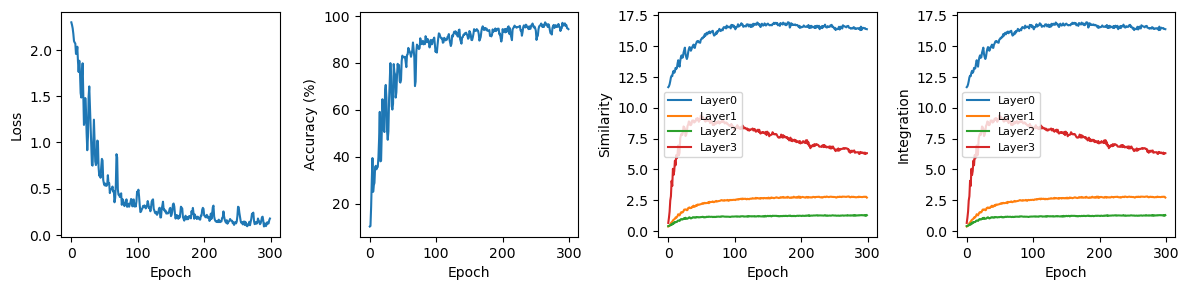

In [126]:
# This code plots absolute values of loss, accuracy, similarity, and integration
# -- useful for knowing what the true (unnormalized) values are --
numEpoch = results['trackLoss'].shape[0]
alignMean = models.CNN2P2.avgFromFull(results['alignFull'])
# Note: similarity and integration are only current -- I changed it to simMean,intMean,simStd,intStd for future reference and for plotting error bars!
fig,ax = plt.subplots(1,4,figsize=(12,3))
ax[0].plot(results['trackLoss'])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(results['trackAccuracy'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy (%)')
for i in range(alignMean.shape[0]):
    ax[2].plot(alignMean[i,:]*100,label=f'Layer{i}')
    ax[3].plot(alignMean[i,:]*100,label=f'Layer{i}')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Similarity')
ax[2].legend(prop={'size':8})
ax[3].set_xlabel('Epoch')
ax[3].set_ylabel('Integration')
ax[3].legend(prop={'size':8})

plt.tight_layout()

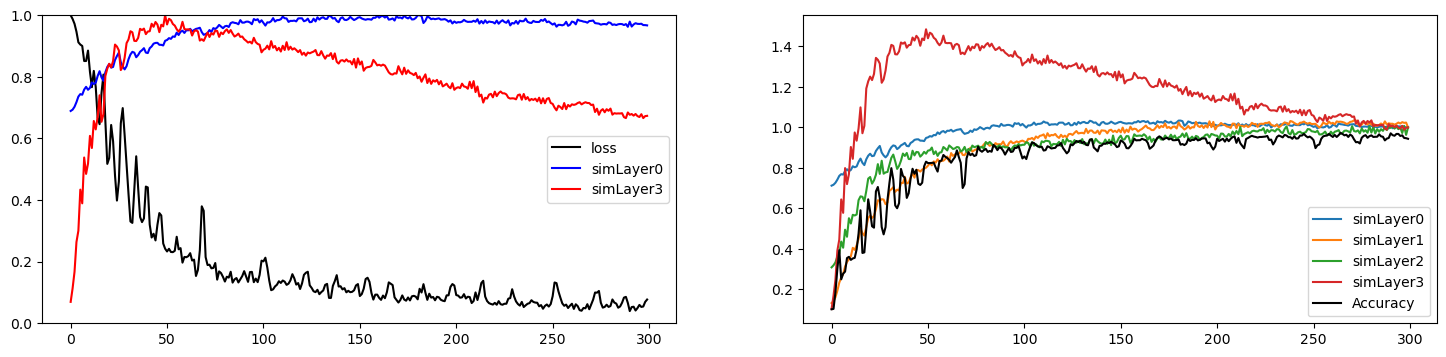

In [127]:
# This code plots relative loss & accuracy with similarity and integration to compare timescales of change
i1 = 0
i2 = 3
fig,ax = plt.subplots(1,2,figsize=(18,4))
ax[0].plot(range(numEpoch), results['trackLoss'] / torch.max(results['trackLoss']), c='k', label='loss')
ax[0].plot(range(numEpoch), alignMean[i1,:] / torch.max(alignMean[i1,:]), c='b', label=f'simLayer{i1}')
ax[0].plot(range(numEpoch), alignMean[i2,:] / torch.max(alignMean[i2,:]), c='r', label=f'simLayer{i2}')
ax[0].set_ylim(0,1)
ax[0].legend(loc='center right')
for i in range(alignMean.shape[0]):
    ax[1].plot(range(numEpoch),alignMean[i,:]/alignMean[i,-1], label=f'simLayer{i}')
ax[1].plot(range(numEpoch),results['trackAccuracy']/100, c='k', label='Accuracy')
ax[1].legend(loc='lower right')

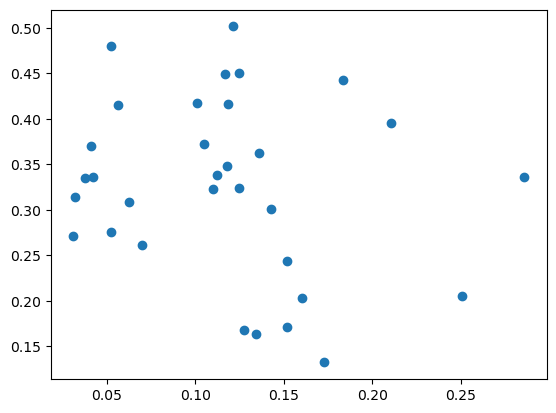

In [128]:
# Compare similarity with change in weights for each layer
layer=0
sf = models.CNN2P2.layerFromFull(results['alignFull'],layer).detach().cpu()
dw = models.CNN2P2.layerFromFull(results['deltaWeights'],layer).detach().cpu()
plt.scatter(sf[:,0], dw[:,-1])

## Main Analysis Code Below
The first block performs multiple runs and saves the data. 
The second block loads the data and transforms it to useable arrays. 
The next group of blocks analyzes and plots the data. 

In [8]:
# Perform many runs
useNet = 'CNN2P2'
iterations = 100
learningRate = (8e-3, 5e-3, 2e-3)
numRuns = 10
numLR = len(learningRate)

if inColab:
    saveDir = "/content/drive/MyDrive/Github/networkAlignmentAnalysis/data/integrationMNIST"
    if not os.path.exists(saveDir): os.makedirs(saveDir)
else:
    saveDir=Path('../data/integrationMNIST')
    if not os.path.exists(saveDir): os.makedirs(saveDir)

runOffset = 0
doMultipleRuns = False
if doMultipleRuns:
    # Do Runs
    for runIdx in range(numRuns):
        for lr in tqdm(range(numLR)):
            print(f"Learning Rate: {lr+1}/{numLR}, Run: {runIdx+1}/{numRuns}...")
            results = nnexp.runExperiment_measureIntegrationMNIST(useNet=useNet,iterations=iterations,learningRate=learningRate[lr],verbose=False,dataPath=dataPath)

            # And Save
            fileName=f'integrationMNIST{runIdx+runOffset}_LR{lr}.pkl'
            with open(saveDir / fileName, 'wb') as f:
                pickle.dump(results, f)

In [ ]:
# Analyze multiple runs (need to do this before running dropout+retraining experiment)
saveDir=Path('data')
fileNames = glob("../data/integrationMNIST/integrationMNIST*.pkl")
NF = len(fileNames)

nets = []
alignFull = []
deltaWeights = []
trackLoss = []
trackAccuracy = []
learningRate = []
runIdx = []
for file in tqdm(fileNames):
    with open(file, 'rb') as f:
        results = pickle.load(f)
        nets.append(results['net'])
        alignFull.append(results['alignFull'])
        deltaWeights.append(results['deltaWeights'])
        trackLoss.append(results['trackLoss'])
        trackAccuracy.append(results['trackAccuracy'])
        runIdx.append(int(file[file.find('\\integrationMNIST')+17:file.find('_LR')]))
        learningRate.append(int(file[file.find('LR')+2:-4]))

# Also keep these (it's the same for each run)
trainloader = results['trainloader']
testloader = results['testloader']
runIdx = np.array(runIdx)
learningRate = np.array(learningRate)
lrVals = np.unique(learningRate)

# Just for the reminder...
print(f"Keys available from results dictionary: {results.keys()}")

In [152]:
# Perform dropout and retraining experiment (long code block!!!)
# -- note: must load results of run before running this block (using the code block above this one)


# -- details: dropout 50%, either from high or low alignment side (of full network e.g. layers 0, 1 & 2) -- 
dropoutFraction = 0.5
dropoutLayer = [0,1,2]
iterations = 30
retrainLearningRate = 1e-2

if inColab:
    saveDir = "/content/drive/MyDrive/Github/networkAlignmentAnalysis/data/integrationMNIST"
    if not os.path.exists(saveDir): os.makedirs(saveDir)
else:
    saveDir=Path('../data/integrationMNIST')
    if not os.path.exists(saveDir): os.makedirs(saveDir)

doRetraining = False
if doRetraining:
    progressBar = tqdm(range(len(runIdx)))
    # For each trained network, save retraining after dropping high and low (dropping out 'dropoutFraction' of neurons in each layer) 
    for netidx in progressBar:
        cRunIdx = runIdx[netidx]
        cLRIdx = learningRate[netidx]
        if cLRIdx!=0: continue # not worth it to do all of them...
        progressBar.set_description(f"Retraining net {netidx+1}/{len(runIdx)} after dropping out {dropoutFraction*100:.1f}% of most aligned weights.")
        
        # Perform dropout from top half of neurons according to alignment
        dropoutIndex = []
        for dl in dropoutLayer:
            idxFinalAlignment = torch.argsort(alignLayer[dl][netidx,:,-1])
            if dl==0:
                numUnits=nets[netidx].conv1.bias.shape[0]
            if dl==1: 
                numUnits=nets[netidx].conv2.bias.shape[0]
            if dl==2: 
                numUnits=nets[netidx].fc1.bias.shape[0]

            # Get number of units to remove, and pick them 
            numUnits2Remove = int(numUnits * dropoutFraction)
            idxRemove = idxFinalAlignment[-numUnits2Remove:]
            
            # Add remove index to dropout list
            dropoutIndex.append(idxRemove)
        
        # The retrain on reduced network
        retrainedDropHi = nnexp.retrainNetwork(nets[netidx], dropoutLayer, dropoutIndex, trainloader, testloader, iterations=iterations, learningRate=retrainLearningRate, verbose=False)
        
        # And Save
        fileName=f'retrainDropHi50{cRunIdx}_LR{cLRIdx}.pkl'
        with open(saveDir / fileName, 'wb') as f:
            pickle.dump(retrainedDropHi, f)
        
        # --------------------------------------------------------------------------------------------------------------------------------------------------------
        progressBar.set_description(f"Retraining net {netidx+1}/{len(runIdx)} after dropping out {dropoutFraction*100:.1f}% of least aligned weights.")
        
        # Perform dropout from bottom half of neurons according to alignment
        dropoutIndex = []
        for dl in dropoutLayer:
            idxFinalAlignment = torch.argsort(alignLayer[dl][netidx,:,-1])
            if dl==0:
                numUnits=nets[netidx].conv1.bias.shape[0]
            if dl==1: 
                numUnits=nets[netidx].conv2.bias.shape[0]
            if dl==2: 
                numUnits=nets[netidx].fc1.bias.shape[0]

            # Get number of units to remove, and pick them 
            numUnits2Remove = int(numUnits * frac2remove)
            idxRemove = idxFinalAlignment[:numUnits2Remove]
            
            # Add remove index to dropout list
            dropoutIndex.append(idxRemove)
        
        # The retrain on reduced network
        retrainedDropLo = nnexp.retrainNetwork(nets[netidx], dropoutLayer, dropoutIndex, trainloader, testloader, iterations=iterations, learningRate=retrainLearningRate, verbose=False)
        
        # And Save
        fileName=f'retrainDropLo50{cRunIdx}_LR{cLRIdx}.pkl'
        with open(saveDir / fileName, 'wb') as f:
            pickle.dump(retrainedDropLo, f)

In [159]:
fileNames = glob("../data/integrationMNIST/retrainDropHi50*.pkl")
file = next(iter(fileNames))
print(file)
print(file[file.find("DropHi50")+8:file.find("_LR")])

../data/integrationMNIST\retrainDropHi500_LR0.pkl
0


In [ ]:
# Analyze multiple runs + retraining runs
saveDir=Path('data')
fileNames = glob("../data/integrationMNIST/integrationMNIST*.pkl")
NF = len(fileNames)

nets = []
alignFull = []
deltaWeights = []
trackLoss = []
trackAccuracy = []
learningRate = []
runIdx = []
for file in tqdm(fileNames):
    with open(file, 'rb') as f:
        cRunIdx = int(file[file.find('\\integrationMNIST')+17:file.find('_LR')])
        cLearningRate = int(file[file.find('LR')+2:-4])
        results = pickle.load(f)
        nets.append(results['net'])
        alignFull.append(results['alignFull'])
        deltaWeights.append(results['deltaWeights'])
        trackLoss.append(results['trackLoss'])
        trackAccuracy.append(results['trackAccuracy'])
        runIdx.append(cRunIdx)
        learningRate.append(cLearningRate)

# Also keep these (it's the same for each run)
trainloader = results['trainloader']
testloader = results['testloader']
runIdx = np.array(runIdx)
learningRate = np.array(learningRate)
lrVals = np.unique(learningRate)

# Just for the reminder...
print(f"Keys available from results dictionary: {results.keys()}")

# Get better formatted summary statistics 
alignLayer0 = []
alignLayer1 = []
alignLayer2 = []
alignLayer3 = []
alignMean = []
dwLayer0 = []
dwLayer1= []
dwLayer2= []
dwLayer3= []
for sf,dw in zip(alignFull,deltaWeights):
    alignMean.append(models.CNN2P2.avgFromFull(sf))
    alignLayer0.append(models.CNN2P2.layerFromFull(sf,0))
    alignLayer1.append(models.CNN2P2.layerFromFull(sf,1))
    alignLayer2.append(models.CNN2P2.layerFromFull(sf,2))
    alignLayer3.append(models.CNN2P2.layerFromFull(sf,3))
    dwLayer0.append(models.CNN2P2.layerFromFull(dw,0))
    dwLayer1.append(models.CNN2P2.layerFromFull(dw,1))
    dwLayer2.append(models.CNN2P2.layerFromFull(dw,2))
    dwLayer3.append(models.CNN2P2.layerFromFull(dw,3))

# Do some helpful change to types and shapes
trackLoss = torch.stack(trackLoss)
trackAccuracy = torch.stack(trackAccuracy)
alignMean = torch.stack(alignMean)
alignLayer = [torch.stack(alignLayer0),torch.stack(alignLayer1),torch.stack(alignLayer2),torch.stack(alignLayer3)]
dwLayer = [torch.stack(dwLayer0),torch.stack(dwLayer1),torch.stack(dwLayer2),torch.stack(dwLayer3)]
del alignLayer0, alignLayer1, alignLayer2, alignLayer3, dwLayer0, dwLayer1, dwLayer2, dwLayer3

# And for reminder, print shapes of them
print(f"TrackLoss.shape:{trackLoss.shape}, TrackAccuracy.shape:{trackAccuracy.shape}")
print(f"AlignMean.shape:{alignMean.shape}, len(AlignLayer):{len(alignLayer)}, alignLayer[0].shape:{alignLayer[0].shape}, len(dwLayer):{len(dwLayer)}, dwLayer[0].shape:{dwLayer[0].shape}")


loadRetrainingData = True
if loadRetrainingData:
    # Get data from retraining runs (start with dropping high alignment neurons)
    fileNames = glob("../data/integrationMNIST/retrainDropHi50*.pkl")
    NF = len(fileNames)

    retrainDoHi = []
    alignFullDoHi = []
    deltaWeightsDoHi = []
    trackLossDoHi = []
    trackAccuracyDoHi = []
    learningRateDoHi = []
    runIdxDoHi = []
    for file in tqdm(fileNames):
        with open(file, 'rb') as f:
            cRunIdx = int(file[file.find("DropHi50")+8:file.find("_LR")])
            cLearningRate = int(file[file.find('LR')+2:-4])
            results = pickle.load(f)
            retrainDoHi.append(results['net'])
            alignFullDoHi.append(results['alignFull'])
            deltaWeightsDoHi.append(results['deltaWeights'])
            trackLossDoHi.append(results['trackLoss'])
            trackAccuracyDoHi.append(results['trackAccuracy'])
            runIdxDoHi.append(cRunIdx)
            learningRateDoHi.append(cLearningRate)

    # Also keep these (it's the same for each run)
    runIdxDoHi = np.array(runIdx)
    learningRateDoHi = np.array(learningRate)
    lrValsDoHi = np.unique(learningRate)

    
    # Get data from retraining runs (continue with dropping low alignment neurons)
    fileNames = glob("../data/integrationMNIST/retrainDropLo50*.pkl")
    NF = len(fileNames)

    retrainDoLo = []
    alignFullDoLo = []
    deltaWeightsDoLo = []
    trackLossDoLo = []
    trackAccuracyDoLo = []
    learningRateDoLo = []
    runIdxDoLo = []
    for file in tqdm(fileNames):
        with open(file, 'rb') as f:
            cRunIdx = int(file[file.find("DropLo50")+8:file.find("_LR")])
            cLearningRate = int(file[file.find('LR')+2:-4])
            results = pickle.load(f)
            retrainDoLo.append(results['net'])
            alignFullDoLo.append(results['alignFull'])
            deltaWeightsDoLo.append(results['deltaWeights'])
            trackLossDoLo.append(results['trackLoss'])
            trackAccuracyDoLo.append(results['trackAccuracy'])
            runIdxDoLo.append(cRunIdx)
            learningRateDoLo.append(cLearningRate)

    # Also keep these (it's the same for each run)
    runIdxDoLo = np.array(runIdx)
    learningRateDoLo = np.array(learningRate)
    lrValsDoLo = np.unique(learningRate)


 33%|███████████████████████████▎                                                      | 10/30 [00:26<00:54,  2.74s/it]

In [ ]:


















# need to write some code to stack retraining data in useful way






















In [10]:
# Analyze test loss with targeted dropout experiment
dropoutFraction = 0.25
numLayers = len(alignLayer)-1
loss_function = nn.CrossEntropyLoss() # Note: this automatically applies softmax...

numRuns = len(alignMean)
loss = torch.zeros((numRuns,numLayers))
lossNoHi = torch.zeros((numRuns,numLayers))
lossNoLo = torch.zeros((numRuns,numLayers))
lossRnd = torch.zeros((numRuns,numLayers))
accuracy = torch.zeros((numRuns,numLayers))
accuracyNoHi = torch.zeros((numRuns,numLayers))
accuracyNoLo = torch.zeros((numRuns,numLayers))
accuracyRnd = torch.zeros((numRuns,numLayers))
for runidx in tqdm(range(numRuns)):
    for layer in range(numLayers):
        num2look = int(dropoutFraction * alignLayer[layer].shape[1])
        idxFinalAlignment = torch.argsort(alignLayer[layer][runidx,:,-1])
        idxHi = idxFinalAlignment[-num2look:]
        idxLo = idxFinalAlignment[:num2look]
        
        # For each network / layer combination
        numAttempted = 0
        for batch in testloader:
            images,label = batch
            images = images.to(DEVICE)
            label = label.to(DEVICE)
            numAttempted += images.shape[0]
            
            # Get loss for no high
            outputs = models.CNN2P2.targetedDropout(nets[runidx], images, idxHi, layer)
            lossNoHi[runidx,layer] += loss_function(outputs,label).item()
            output1 = torch.argmax(outputs,axis=1)
            accuracyNoHi[runidx,layer] += sum(output1==label).cpu()
            # Get loss for no low
            outputs = models.CNN2P2.targetedDropout(nets[runidx], images, idxLo, layer)
            lossNoLo[runidx,layer] += loss_function(outputs,label).item()
            output1 = torch.argmax(outputs,axis=1)
            accuracyNoLo[runidx,layer] += sum(output1==label).cpu()
            
            # Get general loss
            outputs = nets[runidx](images)
            loss[runidx,layer] += loss_function(outputs,label).item()
            output1 = torch.argmax(outputs,axis=1)
            accuracy[runidx,layer] += sum(output1==label).cpu()
            # Get loss for random dropout
            idxRandom = torch.randperm(alignLayer[layer].shape[0])[:num2look]
            outputs = models.CNN2P2.targetedDropout(nets[runidx], images, idxRandom, layer)
            lossRnd[runidx,layer] += loss_function(outputs,label).item()
            output1 = torch.argmax(outputs,axis=1)
            accuracyRnd[runidx,layer] += sum(output1==label).cpu()
            
accuracy = 100*accuracy/numAttempted
accuracyNoHi = 100*accuracyNoHi/numAttempted
accuracyNoLo = 100*accuracyNoLo/numAttempted
accuracyRnd = 100*accuracyRnd/numAttempted

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:47<00:00,  3.57s/it]


In [11]:
# Add dropout experiment where we do a progressive dropout from lowest to highest alignment and vice-versa
# At each layer independently, and also at all layers together!
numRuns = len(alignMean)
numLayers = len(alignLayer)-1
numDrops = 9 # divide fraction evenly 
dropFraction = np.linspace(0,1,numDrops+2)[1:-1]
loss_function = nn.CrossEntropyLoss() # Note: this automatically applies softmax...

progDropLossLo = torch.zeros((numRuns,numLayers,numDrops))
progDropLossHi = torch.zeros((numRuns,numLayers,numDrops))
progDropAccuracyLo = torch.zeros((numRuns,numLayers,numDrops))
progDropAccuracyHi = torch.zeros((numRuns,numLayers,numDrops))

progressBar = tqdm(testloader)
for batch in progressBar:
    images,label = batch
    images = images.to(DEVICE)
    label = label.to(DEVICE)
    
    for runidx in range(numRuns):
        for layer in range(numLayers):
            progressBar.set_description(f"RunIdx:{runidx+1}/{numRuns}, Layer:{layer+1}/{numLayers}")
                
            idxFinalAlignment = torch.argsort(alignLayer[layer][runidx,:,-1])
            for dropFrac in range(numDrops):
                num2look = int(dropFraction[dropFrac] * alignLayer[layer].shape[1])
                idxHi = idxFinalAlignment[-num2look:]
                idxLo = idxFinalAlignment[:num2look]
                
                # Get loss for progressive dropout of hi
                outputs = models.CNN2P2.targetedDropout(nets[runidx], images, idxHi, layer)
                progDropLossHi[runidx,layer,dropFrac] += loss_function(outputs,label).item()
                output1 = torch.argmax(outputs,axis=1)
                progDropAccuracyHi[runidx,layer,dropFrac] += sum(output1==label).cpu()
                
                # Get loss for progressive dropout of low
                outputs = models.CNN2P2.targetedDropout(nets[runidx], images, idxLo, layer)
                progDropLossLo[runidx,layer,dropFrac] += loss_function(outputs,label).item()
                output1 = torch.argmax(outputs,axis=1)
                progDropAccuracyLo[runidx,layer,dropFrac] += sum(output1==label).cpu()
                
# Normalize correctly
progDropLossLo = progDropLossLo/len(testloader)
progDropLossHi = progDropLossHi/len(testloader)
progDropAccuracyLo = 100*progDropAccuracyLo/len(testloader.dataset)
progDropAccuracyHi = 100*progDropAccuracyHi/len(testloader.dataset)

RunIdx:30/30, Layer:3/3: 100%|█████████████████████████████████████████████████████████| 10/10 [01:30<00:00,  9.00s/it]


In [12]:
# Compare activations, incoming weight norms and outgoing weight norms with alignment of each node
numRuns = len(alignMean)
numLayers = len(alignLayer)-1
numBatches = len(trainloader)
dimVariance = [(0,2,3),(0,2,3),(0)]
actVariance = []
weightNorms = []
outgoingNorms = []
for layer in range(numLayers):
    numNodes = alignLayer[layer].shape[1]
    actVariance.append(torch.zeros((numRuns,numNodes)))
    weightNorms.append(torch.zeros((numRuns,numNodes)))
    outgoingNorms.append(torch.zeros((numRuns,numNodes)))

# Measure activation variance
for batch in tqdm(trainloader):
    images,label = batch
    images = images.to(DEVICE)
    label = label.to(DEVICE)

    for runidx in range(numRuns):
        # Get activations for this batch
        cacts = nets[runidx].getActivations(images)
        for layer in range(numLayers):
            actVariance[layer][runidx,:] += torch.var(cacts[layer],dim=dimVariance[layer]).clone().detach().cpu()

for layer in range(numLayers):
    actVariance[layer] = actVariance[layer] / len(trainloader)
            
# Measure weight norms
print("Oops: haven't figured out how to compute outgoing norm of convolutional to fully connected layer")
for runidx in range(numRuns):
    weightNorms[0][runidx,:] = torch.norm(nets[runidx].conv1.weight.detach(),p=2,dim=(1,2,3))
    weightNorms[1][runidx,:] = torch.norm(nets[runidx].conv2.weight.detach(),p=2,dim=(1,2,3))
    weightNorms[2][runidx,:] = torch.norm(nets[runidx].fc1.weight.detach(),p=2,dim=1)
    outgoingNorms[0][runidx,:] = torch.norm(nets[runidx].conv2.weight.detach(),p=2,dim=(0,2,3))
    # outgoingNorms[1][runidx,:] = torch.norm(nets[
    outgoingNorms[2][runidx,:] = torch.norm(nets[runidx].o.weight.detach(),p=2,dim=0)
    

[autoreload of deepnets.nnExperiments failed: Traceback (most recent call last):
  File "C:\Users\andrew\anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\andrew\anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 455, in superreload
    module = reload(module)
  File "C:\Users\andrew\anaconda3\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "C:\Users\andrew\Documents\GitHub\networkAlignmentAnalysis\deepnets\..\deepnets\nnExperiments.py", line 136
    def downloadMNIST(batchSize=1000

Oops: haven't figured out how to compute outgoing norm of convolutional to fully connected layer


In [ ]:
# Measure alignment between the input and the delta-weight of each node










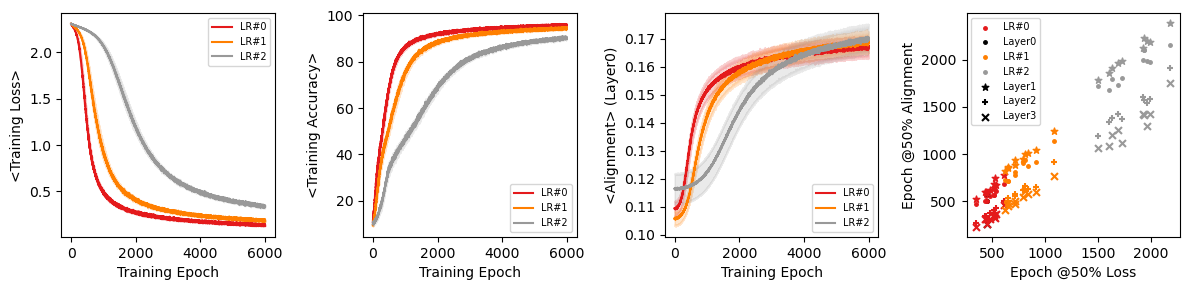

In [13]:
# Plot Analysis of Loss Trajectory and Similarity Trajectory 

# Create smoothing function
kernelSize = 10 # for smoothing trajectories
missingPoints = (kernelSize-1)
kernel = np.ones(kernelSize)/kernelSize
smooth = lambda x: np.convolve(x, kernel, mode='valid')

# Shapes and Size
NR,NT = trackLoss.shape
NL = len(alignLayer)
lrVals = np.unique(learningRate)
NLR = len(lrVals)

# Define colormap
cmap = cm.get_cmap('Set1', NLR).colors

# Make summary figure
showLayer = 0
fig,ax = plt.subplots(1,4,figsize=(12,3))

fontsize=7

# Plot loss trajectory
for lr in range(NLR):
    lridx = learningRate==lrVals[lr]
    mnLoss = torch.mean(trackLoss[lridx],dim=0)
    seLoss = torch.std(trackLoss[lridx],dim=0)/np.sqrt(np.sum(lridx))
    ax[0].plot(range(NT), mnLoss, c=cmap[lr], label=f'LR#{lr}')
    ax[0].fill_between(range(NT), mnLoss+seLoss, mnLoss-seLoss, color=cmap[lr], alpha=0.2)
ax[0].set_xlabel('Training Epoch')
ax[0].set_ylabel('<Training Loss>')
ax[0].legend(fontsize=fontsize)

# Plot accuracy trajectory
for lr in range(NLR):
    lridx = learningRate==lrVals[lr]
    mnAcc = torch.mean(trackAccuracy[lridx],dim=0)
    seAcc = torch.std(trackAccuracy[lridx],dim=0)/np.sqrt(np.sum(lridx))
    ax[1].plot(range(NT), mnAcc, c=cmap[lr], label=f'LR#{lr}')
    ax[1].fill_between(range(NT), mnAcc+seAcc, mnAcc-seAcc, color=cmap[lr], edgecolor=cmap[lr], alpha=0.2)
ax[1].set_xlabel('Training Epoch')
ax[1].set_ylabel('<Training Accuracy>')
ax[1].legend(fontsize=fontsize)

# Plot alignment trajectory for one layer
for lr in range(NLR):
    lridx = learningRate==lrVals[lr]
    mnAlign = torch.mean(alignMean[lridx,showLayer],dim=0)
    seAlign = torch.std(alignMean[lridx,showLayer],dim=0)/np.sqrt(np.sum(lridx))
    ax[2].plot(range(NT), mnAlign, c=cmap[lr], label=f'LR#{lr}')
    ax[2].fill_between(range(NT), mnAlign+seAlign, mnAlign-seAlign, color=cmap[lr], edgecolor=cmap[lr], alpha=0.2)
ax[2].set_xlabel('Training Epoch')
ax[2].set_ylabel(f'<Alignment> (Layer{showLayer})')
ax[2].legend(fontsize=fontsize, loc='lower right')

# Compare 50% point for loss and alignment for one layer
mrkTypes=['.','*','+','x']
for slayer in range(NL):
    for lr in range(NLR):
        lridx = learningRate==lrVals[lr]
        loss50 = torch.zeros(np.sum(lridx))
        align50 = torch.zeros(np.sum(lridx))
        for idx,lossAlign in enumerate(zip(trackLoss[lridx],alignMean[lridx,slayer])):
            closs,calign = lossAlign
            loss50[idx] = torch.where(closs<=np.mean([closs.min(),closs.max()]))[0][0]
            align50[idx] = torch.where(calign>=np.mean([calign.min(),calign.max()]))[0][0]
        if slayer==0:
            ax[3].scatter(loss50[0],align50[0],color=cmap[lr],s=25,marker=mrkTypes[slayer],label=f'LR#{lr}')
        if lr==0:
            ax[3].scatter(loss50[0],align50[0],color='k',s=25,marker=mrkTypes[slayer],label=f'Layer{slayer}')
        ax[3].scatter(loss50,align50,color=cmap[lr],s=25,marker=mrkTypes[slayer])
ax[3].set_xlabel('Epoch @50% Loss')
ax[3].set_ylabel(f'Epoch @50% Alignment')
ax[3].legend(fontsize=fontsize)

plt.tight_layout()

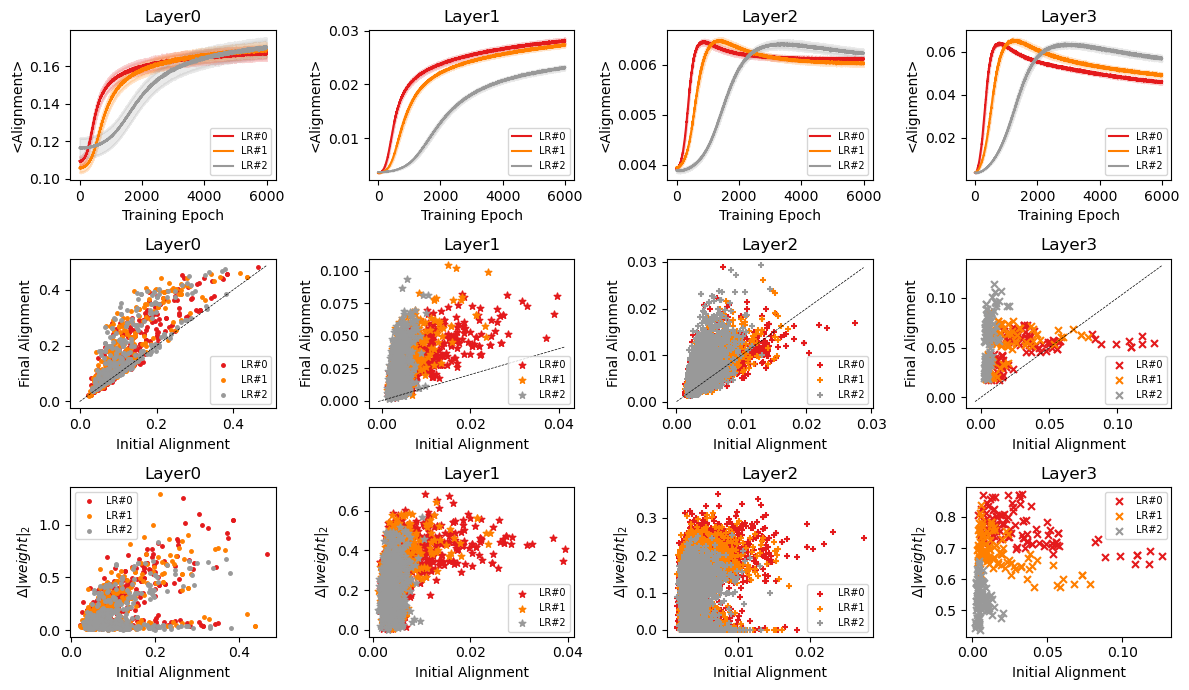

In [14]:
# Plot detailed analysis of node properties

# Make summary figure
showLayer = 0
fig,ax = plt.subplots(3,4,figsize=(12,7))

fontsize=7
alpha=1

avgFraction = 0.1
avgPoints = int(trackLoss.shape[1]*avgFraction)

# Compare initial and final alignment for each node
for slayer in range(NL):
    for lr in range(NLR):
        lridx = learningRate==lrVals[lr]
        mnAlign = torch.mean(alignMean[lridx,slayer],dim=0)
        seAlign = torch.std(alignMean[lridx,slayer],dim=0)/np.sqrt(np.sum(lridx))
        ax[0,slayer].plot(range(NT), mnAlign, c=cmap[lr], label=f'LR#{lr}')
        ax[0,slayer].fill_between(range(NT), mnAlign+seAlign, mnAlign-seAlign, color=cmap[lr], edgecolor=cmap[lr], alpha=0.2)
    ax[0,slayer].set_xlabel('Training Epoch')
    ax[0,slayer].set_ylabel(f'<Alignment>')
    ax[0,slayer].set_title(f'Layer{slayer}')
    ax[0,slayer].legend(fontsize=fontsize, loc='best')
    
# Compare initial and final alignment for each node
for slayer in range(NL):
    for lr in range(NLR):
        lridx = learningRate==lrVals[lr]
        cinit = torch.mean(alignLayer[slayer][lridx,:,:avgPoints],dim=2)
        cfinal = torch.mean(alignLayer[slayer][lridx,:,-avgPoints:],dim=2)
        ax[1,slayer].scatter(cinit[0], cfinal[0], color=cmap[lr], s=25,marker=mrkTypes[slayer], alpha=alpha, label=f'LR#{lr}')
        ax[1,slayer].scatter(cinit, cfinal, color=cmap[lr], s=25,marker=mrkTypes[slayer], alpha=alpha)
    xLim=ax[1,slayer].get_xlim()
    ax[1,slayer].plot(xLim,xLim,c='k',linewidth=0.5,linestyle='--')
    ax[1,slayer].set_xlabel('Initial Alignment')
    ax[1,slayer].set_ylabel('Final Alignment')
    ax[1,slayer].set_title(f'Layer{slayer}')
    ax[1,slayer].legend(fontsize=fontsize,loc='lower right')

# Compare initial alignment and norm change in weight for each node
avgUntil = 0.1
avgPoints = int(NT*avgUntil)
dwAvg = 0.1
dwPoints = int(NT*dwAvg)
for slayer in range(NL):
    for lr in range(NLR):
        lridx = learningRate==lrVals[lr]
        cAlign = torch.mean(alignLayer[slayer][lridx,:,:avgPoints],dim=2)
        cChange = torch.mean(dwLayer[slayer][lridx,:,-dwPoints:],dim=2)
        ax[2,slayer].scatter(cAlign[0], cChange[0], color=cmap[lr], s=25,marker=mrkTypes[slayer], alpha=alpha, label=f'LR#{lr}')
        ax[2,slayer].scatter(cAlign, cChange, color=cmap[lr], s=25,marker=mrkTypes[slayer], alpha=alpha)
    ax[2,slayer].set_xlabel('Initial Alignment')
    ax[2,slayer].set_ylabel('$\u0394|weight|_2$')
    ax[2,slayer].set_title(f'Layer{slayer}')
    ax[2,slayer].legend(fontsize=fontsize,loc='best')

plt.tight_layout()

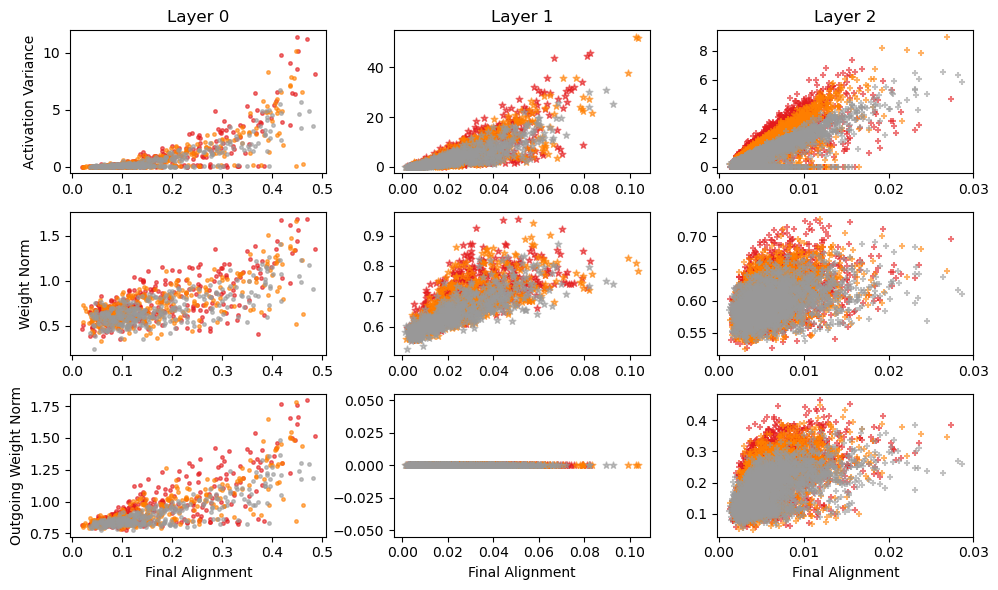

In [15]:
# Plot analysis of weight norm and activation variance for each node
mkrSize = 25
alpha=0.6

fig,ax = plt.subplots(3,numLayers,figsize=(10,6))
for lr in range(NLR):
    lridx = learningRate==lrVals[lr]
    for slayer in range(numLayers):
        ax[0,slayer].scatter(alignLayer[slayer][lridx,:,-1], actVariance[slayer][lridx,:], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
        ax[1,slayer].scatter(alignLayer[slayer][lridx,:,-1], weightNorms[slayer][lridx,:], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
        ax[2,slayer].scatter(alignLayer[slayer][lridx,:,-1], outgoingNorms[slayer][lridx,:], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
        ax[0,slayer].set_title(f'Layer {slayer}')
        
for slayer in range(numLayers): ax[2,slayer].set_xlabel('Final Alignment')
ax[0,0].set_ylabel('Activation Variance')
ax[1,0].set_ylabel('Weight Norm')
ax[2,0].set_ylabel('Outgoing Weight Norm')

plt.tight_layout()

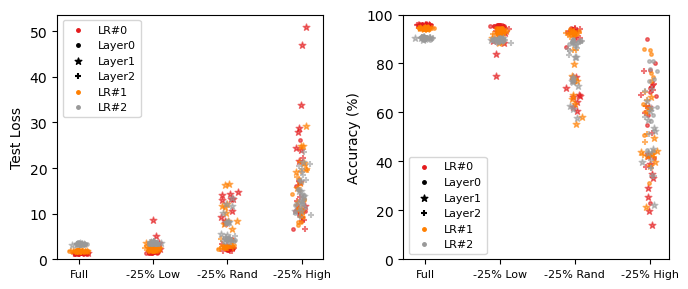

In [16]:
# Plot Results of Targeted Dropout Experiment
mkrSize = 25
rndSpread = 0.05
alpha = 0.6
fontsize=8

fig,ax = plt.subplots(1,2,figsize=(7,3))
for lr in range(NLR):
    lridx = learningRate==lrVals[lr]    
    for slayer in range(NL-1):
        if slayer==0:
            ax[0].scatter(0, -1*loss[np.where(lridx)[0][0],slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=1, label=f'LR#{lr}')
            ax[1].scatter(0, -1*accuracy[np.where(lridx)[0][0],slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=1, label=f'LR#{lr}')
        if lr==0:
            ax[0].scatter(0, -1*loss[np.where(lridx)[0][0],slayer], color='k', s=mkrSize, marker=mrkTypes[slayer], alpha=1, label=f'Layer{slayer}')
            ax[1].scatter(0, -1*accuracy[np.where(lridx)[0][0],slayer], color='k', s=mkrSize, marker=mrkTypes[slayer], alpha=1, label=f'Layer{slayer}')
        ax[0].scatter(torch.normal(0,rndSpread,(np.sum(lridx),1)), loss[lridx,slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
        ax[0].scatter(torch.normal(1,rndSpread,(np.sum(lridx),1)), lossNoLo[lridx,slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
        ax[0].scatter(torch.normal(2,rndSpread,(np.sum(lridx),1)), lossRnd[lridx,slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
        ax[0].scatter(torch.normal(3,rndSpread,(np.sum(lridx),1)), lossNoHi[lridx,slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)

        ax[1].scatter(torch.normal(0,rndSpread,(np.sum(lridx),1)), accuracy[lridx,slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
        ax[1].scatter(torch.normal(1,rndSpread,(np.sum(lridx),1)), accuracyNoLo[lridx,slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
        ax[1].scatter(torch.normal(2,rndSpread,(np.sum(lridx),1)), accuracyRnd[lridx,slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
        ax[1].scatter(torch.normal(3,rndSpread,(np.sum(lridx),1)), accuracyNoHi[lridx,slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
xTickLabel=['Full','-25% Low','-25% Rand','-25% High']
ax[0].set_xticks([0,1,2,3],labels=xTickLabel,fontsize=fontsize)
ax[1].set_xticks([0,1,2,3],labels=xTickLabel,fontsize=fontsize)
ax[0].set_ylim(0,None)
ax[1].set_ylim(0,100)
ax[0].set_ylabel('Test Loss')
ax[1].set_ylabel('Accuracy (%)')
ax[0].legend(fontsize=fontsize,loc='best')
ax[1].legend(fontsize=fontsize,loc='best')

plt.tight_layout();

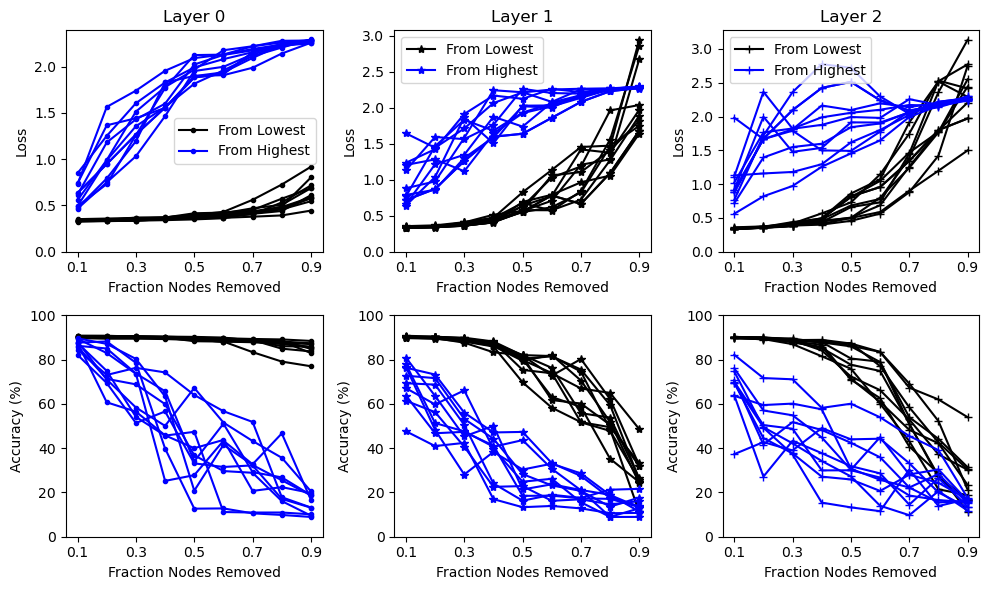

In [17]:
# Plot results of progressive loss experiment

fig,ax = plt.subplots(2,NL-1,figsize=(10,6))
useLR = 0
for slayer in range(NL-1):
    # For legend
    ax[0,slayer].plot(range(numDrops), progDropLossLo[np.where(lridx)[0][0],slayer,:], c='k', marker=mrkTypes[slayer], label='From Lowest')
    ax[0,slayer].plot(range(numDrops), progDropLossHi[np.where(lridx)[0][0],slayer,:], c='b', marker=mrkTypes[slayer], label='From Highest')
    
    ax[0,slayer].plot(range(numDrops), progDropLossLo[lridx,slayer,:].T, c='k', marker=mrkTypes[slayer])
    ax[0,slayer].plot(range(numDrops), progDropLossHi[lridx,slayer,:].T, c='b', marker=mrkTypes[slayer])
    
    ax[1,slayer].plot(range(numDrops), progDropAccuracyLo[lridx,slayer,:].T, c='k', marker=mrkTypes[slayer])
    ax[1,slayer].plot(range(numDrops), progDropAccuracyHi[lridx,slayer,:].T, c='b', marker=mrkTypes[slayer])
    
    ax[0,slayer].set_title(f'Layer {slayer}')
    ax[0,slayer].set_ylabel('Loss')
    ax[1,slayer].set_ylabel('Accuracy (%)')
    ax[0,slayer].set_xticks(range(0,numDrops,2),labels=np.round(dropFraction[::2]*10)/10)
    ax[1,slayer].set_xticks(range(0,numDrops,2),labels=np.round(dropFraction[::2]*10)/10)
    ax[0,slayer].set_xlabel('Fraction Nodes Removed')
    ax[1,slayer].set_xlabel('Fraction Nodes Removed')
    ax[0,slayer].legend()
    ax[0,slayer].set_ylim(0)
    ax[1,slayer].set_ylim(0,100)
    
plt.tight_layout()

In [ ]:
idxFinalAlignment = torch.argsort(alignLayer[layer][runidx,:,-1])
for dropFrac in range(numDrops):
    num2look = int(dropFraction[dropFrac] * alignLayer[layer].shape[1])
    idxHi = idxFinalAlignment[-num2look:]
    idxLo = idxFinalAlignment[:num2look]

In [124]:
idxRetrain = 0
cLRate = lrVals[learningRate[idxRetrain]]
initLoss, initAccuracy = nnexp.measurePerformance(nets[idxRetrain], testloader, verbose=False)
print(f"Initial loss:{initLoss:.2f}, Initial accuracy:{initAccuracy:.1f}%")

frac2remove = 0.8
rmvFromHi = True
dropoutLayer = [0,1,2]
dropoutIndex = []
for dl in dropoutLayer:
    # Get sorted indices of final alignment
    idxFinalAlignment = torch.argsort(alignLayer[dl][idxRetrain,:,-1])
    
    # Get number of units for requested layer
    if dl==0: 
        numUnits=nets[idxRetrain].conv1.bias.shape[0]
    if dl==1: 
        numUnits=nets[idxRetrain].conv2.bias.shape[0]
    if dl==2: 
        numUnits=nets[idxRetrain].fc1.bias.shape[0]
    
    # Get number of units to remove, and pick them 
    numUnits2Remove = int(numUnits * frac2remove)
    if rmvFromHi:
        idxRemove = idxFinalAlignment[-numUnits2Remove:]
    else:
        idxRemove = idxFinalAlignment[:numUnits2Remove]
    
    # Add remove index to dropout list
    dropoutIndex.append(idxRemove)

retrained = nnexp.retrainNetwork(nets[idxRetrain], dropoutLayer, dropoutIndex, trainloader, testloader, iterations=10, learningRate=cLRate)

postLoss, postAccuracy = nnexp.measurePerformance(retrained['net'], testloader, verbose=False)
print(f"Post retrain loss:{postLoss:.2f}, Post retrain accuracy:{postAccuracy:.2f}%")

Initial loss:0.13, Initial accuracy:95.8%
Initiating retraining experiment using cuda
Post prune loss:2.30, Post prune accuracy:10.3%
Loss in epoch   0: 1.188, Accuracy: 59.30%.
Loss in epoch   1: 0.577, Accuracy: 80.10%.
Loss in epoch   2: 0.420, Accuracy: 86.50%.
Loss in epoch   3: 0.328, Accuracy: 88.80%.
Loss in epoch   4: 0.253, Accuracy: 91.80%.
Loss in epoch   5: 0.295, Accuracy: 90.60%.
Loss in epoch   6: 0.224, Accuracy: 92.00%.
Loss in epoch   7: 0.202, Accuracy: 92.50%.
Loss in epoch   8: 0.168, Accuracy: 94.30%.
Loss in epoch   9: 0.155, Accuracy: 94.90%.
Average loss over test set: 0.17.
Accuracy over test set: 94.59%.
Retraining process has finished in 73.857 seconds.
Post retrain loss:0.17, Post retrain accuracy:94.59%


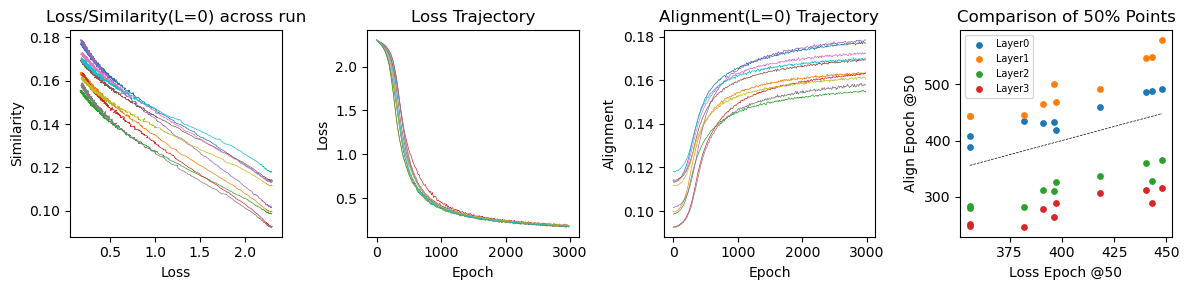

In [ ]:
# Plot Analysis of Loss Trajectory and Similarity Trajectory 

# Create smoothing function
kernelSize = 10 # for smoothing trajectories
missingPoints = (kernelSize-1)
kernel = np.ones(kernelSize)/kernelSize
smooth = lambda x: np.convolve(x, kernel, mode='valid')

# Define colormap
cmap = cm.get_cmap('Set1', NLR).colors

# Shapes and Size
NR = len(trackLoss)
NT = trackLoss[0].shape[0]
NL = len(alignMean[0])
NLR = len(np.unique(learningRate))

# Plot trajectory of loss over similarity
showLayer = 0
numFiles = len(simMean)
fig,ax = plt.subplots(1,4,figsize=(12,3))

for ss,tl in zip(alignMean, trackLoss):
    ax[0].plot(smooth(tl), smooth(ss[showLayer,:]), linewidth=0.5, alpha=1)
ax[0].set_xlabel('Loss')
ax[0].set_ylabel('Similarity')
ax[0].set_title('Loss/Similarity(L=0) across run')

# Get times to 50% of the curves
showLayer = 0
loss50 = missingPoints*torch.ones(NR)
align50 = missingPoints*torch.ones((NL,NR))
for idx,sstl in enumerate(zip(alignMean, trackLoss)):
    ss,tl = sstl
    tl = torch.tensor(smooth(tl))
    # loss50[idx] += torch.argmin(torch.abs(tl - np.mean([tl.min(),tl.max()])))
    loss50[idx] += torch.where(tl<=np.mean([tl.min(),tl.max()]))[0][0]
    ax[1].plot(range(NT-2*missingPoints), smooth(tl), linewidth=0.5)
    ssLayer = torch.tensor(smooth(ss[showLayer,:]))
    ax[2].plot(range(NT-2*missingPoints), smooth(ssLayer), linewidth=0.5)
    for layer in range(NL):
        ssLayer = torch.tensor(smooth(ss[layer,:]))
        # sim50[layer,idx] += torch.argmin(torch.abs(ssLayer - np.mean([ssLayer.min(),ssLayer.max()])))
        align50[layer,idx] += torch.where(ssLayer>=np.mean([ssLayer.min(),ssLayer.max()]))[0][0]
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss Trajectory')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Alignment')
ax[2].set_title(f'Alignment(L={showLayer}) Trajectory')

# And scatter times for each layer
for layer in range(NL):
    ax[3].scatter(loss50, align50[layer,:], label=f"Layer{layer}",s=15)
ax[3].plot([np.min(loss50.numpy()),np.max(loss50.numpy())],[np.min(loss50.numpy()),np.max(loss50.numpy())],c='k',linewidth=0.5,linestyle='--')
ax[3].set_xlabel('Loss Epoch @50')
ax[3].set_ylabel('Align Epoch @50')
ax[3].legend(fontsize=7)
ax[3].set_title('Comparison of 50% Points')

plt.tight_layout()

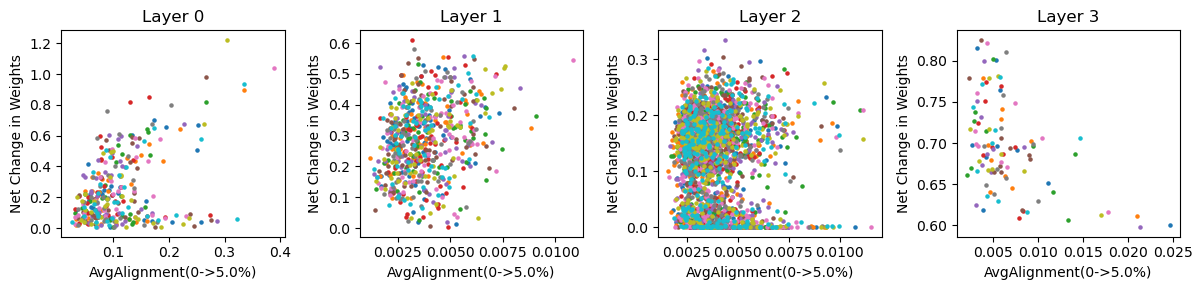

In [ ]:
# Now, compare similarity with change in weights for each layer
avgUntil = 0.05
avgPoints = int(alignLayer0[0].shape[1]*avgUntil)
netSim = lambda sim: torch.mean(sim[:,:avgPoints],dim=1)
dwAvg = 0.01
dwPoints = int(dwLayer0[0].shape[1]*avgUntil)
netDW = lambda dw: torch.mean(dw[:,-dwPoints:],dim=1)

fig,ax = plt.subplots(1,4,figsize=(12,3))
for sim,dw in zip(alignLayer0,dwLayer0):
    ax[0].scatter(netSim(sim),netDW(dw),s=5)
ax[0].set_xlabel(f'AvgAlignment(0->{avgUntil*100}%)')
ax[0].set_ylabel('Net Change in Weights')
ax[0].set_title('Layer 0')

for sim,dw in zip(alignLayer1,dwLayer1):
    ax[1].scatter(netSim(sim),netDW(dw),s=5)
ax[1].set_xlabel(f'AvgAlignment(0->{avgUntil*100}%)')
ax[1].set_ylabel('Net Change in Weights')
ax[1].set_title('Layer 1')

for sim,dw in zip(alignLayer2,dwLayer2):
    ax[2].scatter(netSim(sim),netDW(dw),s=5)
ax[2].set_xlabel(f'AvgAlignment(0->{avgUntil*100}%)')
ax[2].set_ylabel('Net Change in Weights')
ax[2].set_title('Layer 2')

for sim,dw in zip(alignLayer3,dwLayer3):
    ax[3].scatter(netSim(sim),netDW(dw),s=5)
ax[3].set_xlabel(f'AvgAlignment(0->{avgUntil*100}%)')
ax[3].set_ylabel('Net Change in Weights')
ax[3].set_title('Layer 3')

plt.tight_layout()